In [1]:
import numpy as np
import scipy
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
!ls

GWB_covariance.npz  unpack_GWB_cells.ipynb


In [7]:
%matplotlib inline

nside = 8
npol = 1
fwhm = 10.*np.pi/180.

data_file = np.load('./GWB_covariance.npz')
M_pp = data_file['M_p_pp'] 
npix_out = len(M_pp)

Fisher_matrix = np.real(np.swapaxes(M_pp,1,2).reshape(npol*npix_out,npol*npix_out))
dirty_map = np.real(np.swapaxes(data_file['Z_p'],0,1)[0])

Noise_cov, rank = scipy.linalg.pinv(Fisher_matrix, rcond=1.e-5, return_rank = True)
map_estimate = np.einsum('...ik,...k->...i', Noise_cov, dirty_map)

print( 'rank', rank)

rank 403


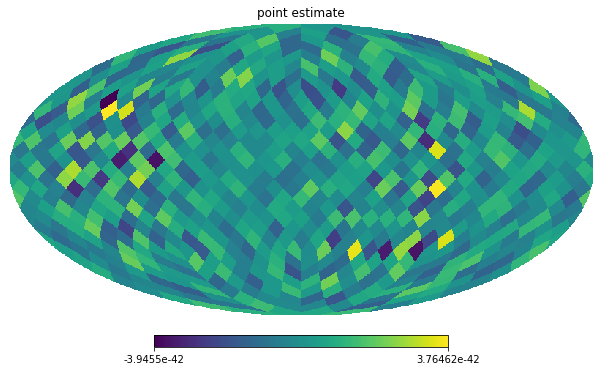

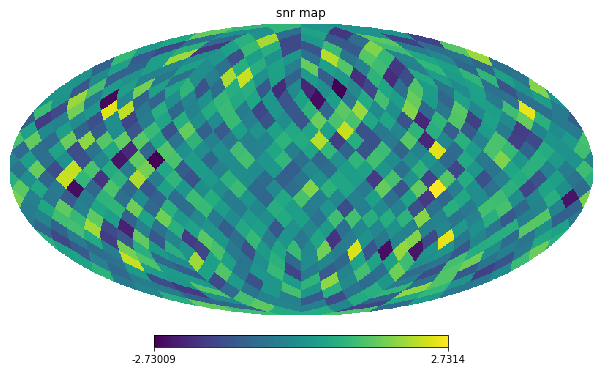

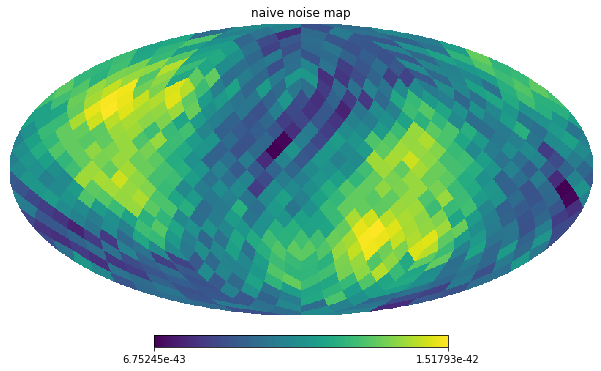

In [8]:
# visualise the maps

hp.mollview(map_estimate, title='point estimate')

naive_snr_map = map_estimate/np.sqrt(np.diag(Noise_cov))
hp.mollview(naive_snr_map, title='snr map')

hp.mollview(np.sqrt(np.diag(Noise_cov)), title='naive noise map')

In [12]:
vec = Fisher_matrix @ map_estimate

lmax = 23
len_alm = hp.Alm.getsize(lmax)

veclm = np.conj(hp.map2alm(vec,lmax=lmax,pol=False)) 

lm_dim = lmax*(lmax+2)+1
rlm_dim = (lmax+1)*(lmax+2)//2

mpp = np.copy(Fisher_matrix)
cplm = np.zeros((rlm_dim,npix_out),dtype=np.complex)
clmlm = np.zeros((lm_dim,lm_dim),dtype=np.complex)

for p in range(npix_out):
    cplm[:,p] = np.conj(hp.map2alm(mpp[p,:],lmax=lmax,pol=False))
    
for l in range(0,lmax+1):
    idxl = l*(l+1)
    for m in range(0,l+1):
        idx_lmp = idxl+m
        idx_lmm = idxl-m
        msign = (-1)**m
        idx = hp.Alm.getidx(lmax,l,m)
        ralm = hp.map2alm(np.real(cplm[idx,:]),lmax=lmax)
        ialm = 1.j*hp.map2alm(np.imag(cplm[idx,:]),lmax=lmax)
        
        if m==0:
            for lp in range(0,lmax+1):
                idx_lp = lp*(lp+1)
                for mp in range(0,lp+1):
                    mpsign = (-1)**mp
                    jdx = hp.Alm.getidx(lmax,lp,mp)
                    clmlm[idx_lmp,idx_lp+mp] = ralm[jdx] + ialm[jdx]
                    if mp > 0: clmlm[idx_lmm,idx_lp-mp] = mpsign*np.conj(clmlm[idx_lmp,idx_lp+mp])
        else:
            for lp in range(0,lmax+1):
                idx_lp = lp*(lp+1)
                for mp in range(0,lp+1):
                    mpsign = (-1)**mp
                    jdx = hp.Alm.getidx(lmax,lp,mp)
                    clmlm[idx_lmp,idx_lp+mp] = ralm[jdx] + ialm[jdx]
                    clmlm[idx_lmm,idx_lp+mp] = msign*(ralm[jdx] - ialm[jdx])
                    if mp > 0: 
                        clmlm[idx_lmm,idx_lp-mp] = msign*mpsign*np.conj(clmlm[idx_lmp,idx_lp+mp])
                        clmlm[idx_lmp,idx_lp-mp] = mpsign/msign*np.conj(clmlm[idx_lmm,idx_lp+mp])
                        
clmlm = np.asmatrix(clmlm)

clmlm_test = np.asmatrix(clmlm)/np.amax(np.abs(clmlm))

#Test for Hermitian
print("Test Hermitianity: ", np.allclose(clmlm_test,clmlm_test.H))
print("Conditioning: ", np.linalg.cond(clmlm))

<ipython-input-12-6c521208ec4c>:12: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cplm = np.zeros((rlm_dim,npix_out),dtype=np.complex)
<ipython-input-12-6c521208ec4c>:13: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clmlm = np.zeros((lm_dim,lm_dim),dtype=np.complex)


Test Hermitianity:  True
Conditioning:  7333890.517207854


<ipython-input-15-96d7a2898eea>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lmax = np.int((np.sqrt(1+8*len(alm))-3)/2)
<ipython-input-15-96d7a2898eea>:6: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out = np

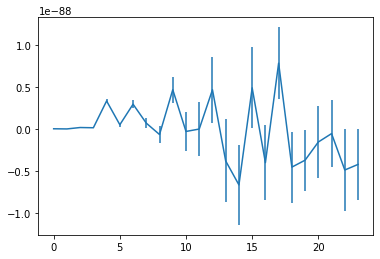

In [15]:
def unpack_alm(alm):
    #lmaxA = np.sqrt(len(A))-1
    lmax = np.int((np.sqrt(1+8*len(alm))-3)/2)
    lm_dim = lmax*(lmax+2)+1
    
    out = np.zeros(lm_dim,dtype=np.complex)
    
    for l in range(0,lmax+1):
        idx_l = l*(l+1)
        for m in range(0,l+1):
            msign = (-1)**m
            idx = hp.Alm.getidx(lmax,l,m)
            if m==0:
                out[idx_l] = alm[idx] 
            else:
                out[idx_l+m] = alm[idx]
                out[idx_l-m] = msign*np.conj(alm[idx])
    return out

def pack_alm(alm):
    lmax = np.int(np.sqrt(len(alm))-1)
    lm_dim = (lmax+1)*(lmax+2)//2
    out = np.zeros(lm_dim, dtype=np.complex)
    for idx in range(lm_dim):
        l,m = hp.Alm.getlm(lmax,idx)
        idx_lm = l*(l+1)+m
        out[idx] = alm[idx_lm]
    return out

ninv = np.linalg.pinv(clmlm, rcond = 1.e-5)

veclm_full = unpack_alm(veclm)
alm = np.dot(ninv,veclm_full)/len(vec) 
alm_new = pack_alm(np.array(alm)[0])
clm_new = pack_alm(np.sqrt(np.real(np.diag(ninv))))/len(vec)

nl = hp.alm2cl(clm_new)

#de-bias the cl esimate
cl = hp.alm2cl(alm_new) - nl

ell = np.arange(len(cl))
sig_cl = np.sqrt(2./(2.*ell+1.))*nl
upp_lim_cl = cl+2.*sig_cl
upp_lim_Dell = upp_lim_cl*ell*(ell+1)/(2.*np.pi)

plt.errorbar(ell,cl,yerr = sig_cl)

np.savez('../comp_2.npz',ells=ell,cell_ww=cl,cell_ww_std=sig_cl)